Train a CNN model for beamforming using hybrid supervised and unsupervised training

In [152]:
import os
import sys
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import importlib
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict

# Get the current working directory
scripts_dir = os.getcwd()
# Go up one level
project_root = os.path.abspath(os.path.join(scripts_dir, '..'))
sys.path.append(project_root)

import src.CNN
importlib.reload(src.CNN)
from src.CNN import ChannelCNN, Trainer

import src.utils
importlib.reload(src.utils)
from src.utils import calculate_sum_rate_sc

import src.sc_wmmse
importlib.reload(src.sc_wmmse)
from src.sc_wmmse import WMMSE_alg_sc

In [ ]:
class setup():
    def __init__(self, n_tx, n_rx, num_streams, num_users, PT):
        self.n_tx = n_tx
        self.n_rx = n_rx
        self.d = num_streams
        self.K = num_users
        self.PT = PT

def proj_power(V, PT_sc):
    num_users_sc = len(V)
    # Projects V according to the constraint
    alph = torch.sqrt(torch.tensor(PT_sc)) / torch.sqrt(torch.tensor(sum([torch.trace(V[str(k)] @ V[str(k)].conj().T) for k in range(num_users_sc)])))
    V_proj = {str(k): alph * V[str(k)] for k in range(num_users_sc)}
    return V_proj

def init_V(H):
    # Initializes V according to Hu's code
    V = {}
    for k in range(len(H_dict)):
        V[str(k)] = (torch.linalg.pinv(H[str(k)] @ H[str(k)].conj().T) @ H[str(k)]).conj().T
    return V

In [173]:
# The setup
num_users = 10
n_tx = 4
n_rx = [2] * num_users
d = [2] * num_users
PT = 100
sig = [1] * num_users
alpha = [1] * num_users
max_iter_alg = 100
tol_alg = 1e-3

num_samples = 5
data = []
for _ in range(num_samples):
    row = {f'user_{i}': torch.randn(n_rx[i], n_tx, dtype=torch.cdouble) for i in range(num_users)}
    data.append(row)

H = pd.DataFrame(data)


V_opt_l = []
srate_opt_l = []
max_index_l = []
for idx, row in H.iterrows():
    H_dict = {str(i): row[i] for i in range(len(row))}
    V_init_l = []
    for _ in range(19):
        dic = {}
        for i in range(num_users):
            dic[str(i)] = torch.randn(n_tx, d[0], dtype=torch.cdouble)
        dic_proj = proj_power(dic, PT)
        V_init_l.append(dic_proj)
    V_init_zf = init_V(H_dict)
    V_init_l.append(V_init_zf)
    
    srate_l = []
    V_f_l = []
    for i in range(20):
        wmm = WMMSE_alg_sc(K=num_users, n_tx=n_tx, n_rx=n_rx, H=H_dict, PT=PT, sig_k=sig, d=d, alpha=alpha, max_iter_alg=max_iter_alg, tol_alg=tol_alg)
        V_l, U_l, W_l = wmm.algorithm(V_init_l[i])
        V_f_l.append(V_l[-1])
        srate_l.append(sum([torch.log2(torch.linalg.det(W_l[-1][str(k)])).real for k in range(num_users)]))

    max_index = srate_l.index(max(srate_l))
    max_index_l.append(max_index)
    V_opt_l.append(V_f_l[max_index])
    srate_opt_l.append(srate_l[max_index])


V_opt_df = pd.DataFrame(V_opt_l)

# V_col = []
# V_init_col = []

# for idx, row in H.iterrows():
#     H_dict = {str(i): row[i] for i in range(len(row))}
#     wmm = WMMSE_alg_sc(K=num_users, n_tx=n_tx, n_rx=n_rx, H=H_dict, PT=PT, sig_k=sig, d=d, alpha=alpha, max_iter_alg=max_iter_alg, tol_alg=tol_alg)
#     V_init = init_V(H_dict)
#     V_init_proj = proj_power(V_init, PT)
#     V_l, U_l, W_l = wmm.algorithm(V_init_proj)
#     V_init_col.append(V_init_proj)
#     V_col.append(V_l[-1])

# V_df = pd.DataFrame(V_col)
# V_init_df = pd.DataFrame(V_init_col)

# # dset = pd.concat([H, V_init_df, V_df], axis=1)
# dset = pd.concat([H, V_df], axis=1)

/var/folders/35/f3dbnk6d3ts1993_z878dt5w0000gn/T/ipykernel_32126/3546425026.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  H_dict = {str(i): row[i] for i in range(len(row))}
/var/folders/35/f3dbnk6d3ts1993_z878dt5w0000gn/T/ipykernel_32126/3611205361.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alph = torch.sqrt(torch.tensor(PT_sc)) / torch.sqrt(torch.tensor(sum([torch.trace(V[str(k)] @ V[str(k)].conj().T) for k in range(num_users_sc)])))
/Users/Ali/Projects/Deep-Unfolding-NN/src/sc_wmmse.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad

In [174]:
dset = pd.concat([H, V_opt_df], axis=1)

In [188]:
tr_to_total = 0.6
last_tr_idx = int(torch.ceil(torch.tensor(tr_to_total*num_samples)))
dset_train = dset.iloc[0:last_tr_idx, :].copy()
dset_test = dset.iloc[last_tr_idx:, :].copy()

In [189]:
# Define the setup
num_users = 10
n_tx = 4
n_rx = 2
num_streams = 2
PT = 100
set_up = setup(n_tx, n_rx, num_streams, num_users, PT)

# Defien the CNN model and the trainer
cn = ChannelCNN(set_up)
tr = Trainer(set_up, cn)

# Supervised training
tr.train_supervised(dataset=dset_train, num_epochs=3000, batch_size=4, lr=0.00001)


Epoch 1/3000, Loss: 0.6255560517311096
Epoch 2/3000, Loss: 0.6254228949546814
Epoch 3/3000, Loss: 0.6252897381782532
Epoch 4/3000, Loss: 0.6251567602157593
Epoch 5/3000, Loss: 0.6250238418579102
Epoch 6/3000, Loss: 0.6248910427093506
Epoch 7/3000, Loss: 0.6247584223747253
Epoch 8/3000, Loss: 0.6246258616447449
Epoch 9/3000, Loss: 0.6244936585426331
Epoch 10/3000, Loss: 0.6243618130683899
Epoch 11/3000, Loss: 0.6242300868034363
Epoch 12/3000, Loss: 0.6240983605384827
Epoch 13/3000, Loss: 0.623966634273529
Epoch 14/3000, Loss: 0.6238349676132202
Epoch 15/3000, Loss: 0.6237035393714905
Epoch 16/3000, Loss: 0.623572051525116
Epoch 17/3000, Loss: 0.6234406232833862
Epoch 18/3000, Loss: 0.6233091950416565
Epoch 19/3000, Loss: 0.6231777667999268
Epoch 20/3000, Loss: 0.623046338558197
Epoch 21/3000, Loss: 0.6229145526885986
Epoch 22/3000, Loss: 0.622782826423645
Epoch 23/3000, Loss: 0.6226513385772705
Epoch 24/3000, Loss: 0.6225196719169617
Epoch 25/3000, Loss: 0.6223881840705872
Epoch 26/3000

In [193]:
tr.train_unsupervised(dataset=dset_train, num_epochs=10, batch_size=2, lr=0.0001, penalty_coef=10)

/Users/Ali/Projects/Deep-Unfolding-NN/src/CNN.py:124: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  H = H.applymap(lambda x: x.to(torch.cdouble))


Epoch 1/10, Loss: -8.005331773706882
Epoch 2/10, Loss: -8.356935709348418
Epoch 3/10, Loss: -8.75832569187681
Epoch 4/10, Loss: -9.224487266677476
Epoch 5/10, Loss: -9.772094462159798
Epoch 6/10, Loss: -10.402971057525113
Epoch 7/10, Loss: -11.0888244416685
Epoch 8/10, Loss: -11.63320761474998
Epoch 9/10, Loss: -11.744091587795278
Epoch 10/10, Loss: -11.619073718507476
Training complete!


In [190]:
def tensor_to_df(x_tensor):
    """
    Converts a tensor of shape (batch_size, 2K, N_r, N_t) back to a DataFrame of complex matrices,
    where each cell contains a complex-valued tensor of shape (N_r, N_t).
    """
    batch_size, double_K, N_r, N_t = x_tensor.shape
    K = double_K // 2

    real_parts = x_tensor[:, :K]
    imag_parts = x_tensor[:, K:]

    data = []
    for i in range(batch_size):
        row = []
        for k in range(K):
            real = real_parts[i, k]
            imag = imag_parts[i, k]
            complex_matrix = torch.complex(real, imag)
            row.append(complex_matrix)
        data.append(row)

    return pd.DataFrame(data)

def df_to_dict(df: pd.DataFrame) -> dict:
    # Converts dataframe to dictionary
    result = {}
    for row_idx in range(len(df)):
        row_dict = {}
        for col_idx in range(len(df.columns)):
            row_dict[str(col_idx)] = df.iloc[row_idx, col_idx].to(torch.cdouble)
        result[str(row_idx)] = row_dict
    return result

def df_to_tensor(x_df):
    # Coverts dataframe to tensor, also real and imaginary parts of tensor entries are seperated.
    batch_size, K = x_df.shape
    N_r, N_t = x_df.iloc[0, 0].shape
    real_parts = torch.empty((batch_size, K, N_r, N_t))
    imag_parts = torch.empty((batch_size, K, N_r, N_t))

    for i in range(batch_size):
        for k in range(K):
            H = x_df.iloc[i, k]  # complex matrix
            real_parts[i, k] = H.real
            imag_parts[i, k] = H.imag

    # Concatenate along channel dimension → shape: (batch_size, 2K, N_r, N_t)
    x_tensor = torch.cat([real_parts, imag_parts], dim=1)
    return x_tensor

/var/folders/35/f3dbnk6d3ts1993_z878dt5w0000gn/T/ipykernel_32126/4058396836.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  H_dict = {str(i): row[i] for i in range(len(row))}


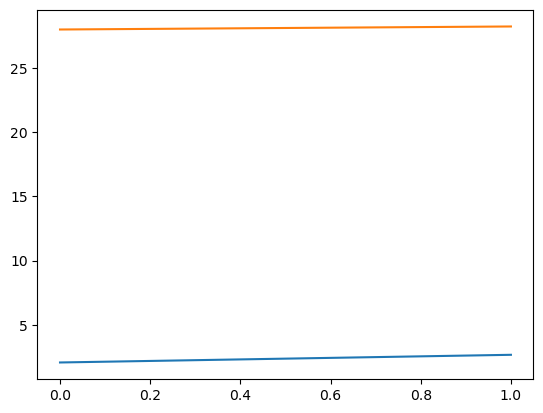

In [194]:
# Plot the predictions for test vs true
H_test = dset_test.iloc[:, 0:num_users].copy().reset_index(drop=True)
H_test_tensor = df_to_tensor(H_test)
out_tensor = tr.model.predict(H_test_tensor)
out_df = tensor_to_df(out_tensor)
out_dict = df_to_dict(out_df)

srate_pred = []
for idx, row in H_test.iterrows():
    H_dict = {str(i): row[i] for i in range(len(row))}
    srate_pred.append(calculate_sum_rate_sc(H_dict, out_dict[str(idx)], alpha, sig).real)

plt.plot(srate_pred)
plt.plot(srate_opt_l[last_tr_idx:])

/var/folders/35/f3dbnk6d3ts1993_z878dt5w0000gn/T/ipykernel_32126/682375721.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  H_dict = {str(i): row[i] for i in range(len(row))}


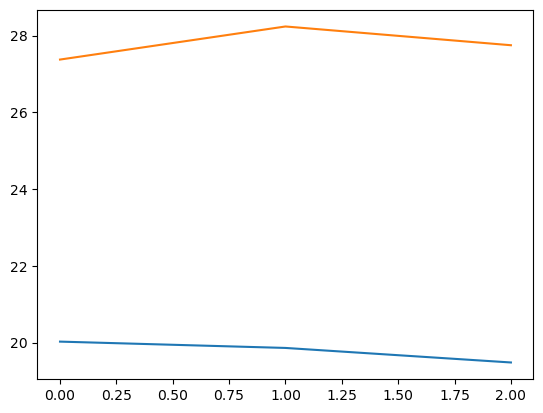

In [195]:
# Plot the predictions for train vs true
H_train = dset_train.iloc[:, 0:num_users].copy().reset_index(drop=True)
H_train_tensor = df_to_tensor(H_train)
out_tensor = tr.model.predict(H_train_tensor)
out_df = tensor_to_df(out_tensor)
out_dict = df_to_dict(out_df)

srate_pred = []
for idx, row in H_train.iterrows():
    H_dict = {str(i): row[i] for i in range(len(row))}
    srate_pred.append(calculate_sum_rate_sc(H_dict, out_dict[str(idx)], alpha, sig).real)

plt.plot(srate_pred)
plt.plot(srate_opt_l[:last_tr_idx])